## C# vs Python programmers in 2018

### Overall distribution

In [1]:
# Load the usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import locale

In [2]:
# Load the data from 2018
data2018 = pd.read_csv('data/2018/survey_results_public.csv', low_memory=False)

In [3]:
# Separate our two languages in separate columns
for language in ['C#', 'Python']:
    data2018[language] = data2018['LanguageWorkedWith'].map(lambda c: language in str(c).split(';'))

In [4]:
def csharp_or_python(col):
    ''' Helper functions for creating unique column'''
    if col['C#'] and col['Python']:
        return 'Both'
    elif col['C#']:
        return 'C#'
    elif col['Python']:
        return 'Python'
    return 'Neither'

In [5]:
combined_column = 'csharp_or_python'
data2018[combined_column] = data2018.apply(lambda col: csharp_or_python(col), axis=1)
data2018.loc[:5, ['C#', 'Python', combined_column]]

,C#,Python,csharp_or_python
0,False,True,Python
1,False,True,Python
2,False,False,Neither
3,True,False,C#
4,False,False,Neither
5,False,True,Python


In [6]:
group_count = data2018.groupby(combined_column).size()
group_count.sort_values()

csharp_or_python
Both        8722
C#         18232
Python     21637
Neither    50264
dtype: int64

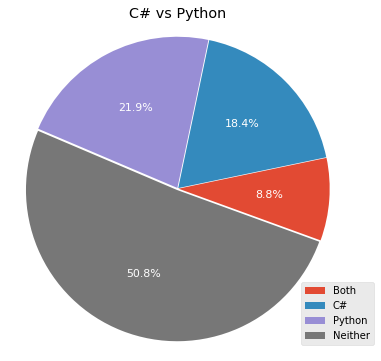

In [7]:
# Create a pie chart of segments in 2018
plt.style.use('ggplot')

fig, ax = plt.subplots(1, figsize=(6, 6))
wedges, texts, autotexts = ax.pie(group_count.sort_values(), startangle=-20, explode=(0.005,0.005,0.005,0.01),
       textprops=dict(color='white'), autopct='%1.1f%%')

plt.setp(autotexts, size=11, weight='normal')
ax.axis('equal')  
plt.legend(group_count.sort_values().index, loc='lower right',
          bbox_to_anchor=(1.1, 0, 0, 0))
ax.set_title('C# vs Python')
plt.show()

### Analyzing behaviorial differences between the groups

In [8]:
# We start with the analysis of amounts of exercise
data2018.loc[:, 'Exercise'].value_counts(normalize=True).index

Index(['I don't typically exercise', '1 - 2 times per week',
       '3 - 4 times per week', 'Daily or almost every day'],
      dtype='object')

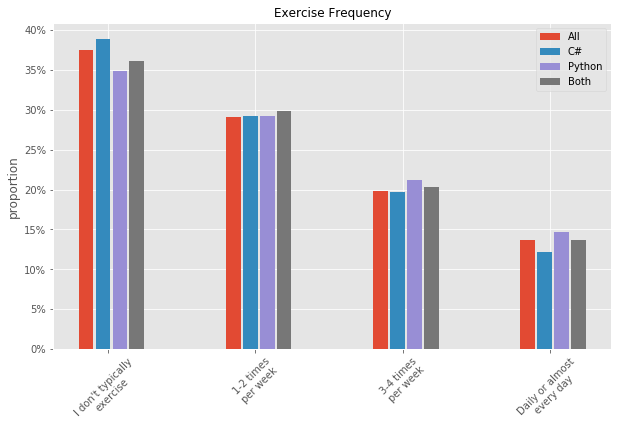

In [9]:
# Plot the exercise behavior of the different groups
fig, ax = plt.subplots(1, figsize=(10, 6))
positions = [1,3,5,7] 
width = .2
padding = .03
ax.bar(positions, data2018['Exercise'].value_counts(normalize=True), width=width)
ax.bar([p+width+padding for p in positions], 
       data2018.loc[data2018[combined_column] == 'C#', 'Exercise'].value_counts(normalize=True), width=width)
ax.bar([p+2*width+2*padding for p in positions],
       data2018.loc[data2018[combined_column] == 'Python', 'Exercise'].value_counts(normalize=True), 
       width=width, label='foo')
ax.bar([p+3*width+3*padding for p in positions],
       data2018.loc[data2018[combined_column] == 'Both', 'Exercise'].value_counts(normalize=True), 
       width=width)
ax.set_ylabel('proportion')
ax.set_xticks([i+0.3 for i in [1,3,5,7]])
ax.set_xticklabels(['I don\'t typically\nexercise', '1-2 times\nper week','3-4 times\nper week','Daily or almost\nevery day'],
                  rotation=45)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _ : locale.format_string("%d%%", x*100)))
plt.title('Exercise Frequency', fontsize=12)
plt.legend(['All', 'C#', 'Python', 'Both'])
plt.show()

### Bootstrap sampling

We use bootstrap sampling to analyze the differences in the groups.

In [10]:
# Create the base distribution of the groups
distribution = data2018['Exercise']
distribution.value_counts(normalize=True)

I don't typically exercise    0.374369
1 - 2 times per week          0.290287
3 - 4 times per week          0.198563
Daily or almost every day     0.136781
Name: Exercise, dtype: float64

In [11]:
# Calculate confidence intervall for python programmers by sampling from the base distribution
generated_distributions = [np.random.choice(distribution, sum(data2018[combined_column] == 'Python')) for r in range(1000)]

In [12]:
# Converting the sampled distributions into percentages
distribution_percentages = [pd.Series(generated_distributions[d]).value_counts(normalize=True).values for d in range(1000)]

In [13]:
# Plot the conficence intervals
percentiles = np.percentile(distribution_percentages, [97.5, 2.5], axis=0)
percentiles

array([[0.38177981, 0.29732612, 0.20455452, 0.14197671],
       [0.36716411, 0.28355247, 0.19312207, 0.13134903]])

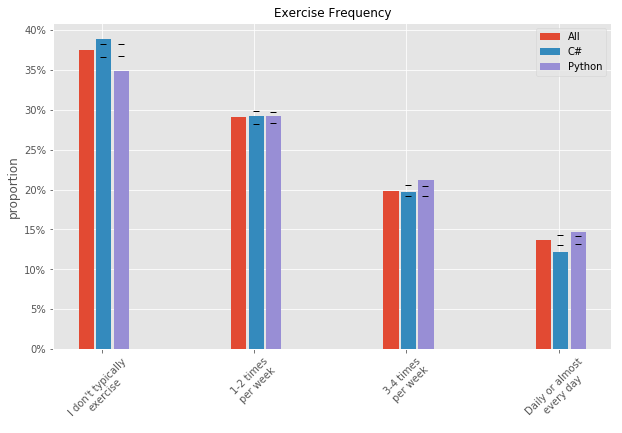

In [14]:
# Create a combined plot with the confidence intervalls
# Note: This plot has not been optimized for performance and can take a while!

fig, ax = plt.subplots(1, figsize=(10, 6))
positions = [1,3,5,7] 
width = .2
padding = .03
ax.bar(positions, data2018['Exercise'].value_counts(normalize=True), width=width)
ax.bar([p+width+padding for p in positions], 
       data2018.loc[data2018[combined_column] == 'C#', 'Exercise'].value_counts(normalize=True), width=width)
ax.bar([p+2*width+2*padding for p in positions],
       data2018.loc[data2018[combined_column] == 'Python', 'Exercise'].value_counts(normalize=True), 
       width=width)

ax.set_ylabel('proportion')
ax.set_xticks([p+width for p in positions],)
ax.set_xticklabels(['I don\'t typically\nexercise', '1-2 times\nper week','3-4 times\nper week','Daily or almost\nevery day'],
                  rotation=45)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _ : locale.format_string("%d%%", x*100)))
plt.title('Exercise Frequency', fontsize=12)
plt.legend(['All', 'C#', 'Python'])

thickness = .04
number_of_samplings = 10000

# Do bootstrap sampling and show confidence intervalls
for lang, i in zip(['C#', 'Python'], [1,2]):
    generated_distributions = [np.random.choice(distribution, sum(data2018[combined_column] == lang)) 
                               for r in range(number_of_samplings)]
    distribution_percentages = [pd.Series(generated_distributions[r]).value_counts(normalize=True).values 
                                for r in range(number_of_samplings)]
    percentiles = np.percentile(distribution_percentages, [97.5, 2.5], axis=0)

    for j in range(4):
        offset = i*width+i*.025
        plt.hlines(percentiles[0, j], positions[j]-thickness+offset, positions[j]+thickness+offset, 
                   color='black', linewidth=1)
        plt.hlines(percentiles[1, j], positions[j]-thickness+offset, positions[j]+thickness+offset, 
                   color='black', linewidth=1)
plt.show()

### Chi-Squared Goodness-Of-Fit Test

First we compare the distributions with the groups with the base line distribution

In [16]:
# Plot a frequency table of the distribution
pd.crosstab(data2018[combined_column], data2018.Exercise, normalize=True)

Exercise,1 - 2 times per week,3 - 4 times per week,Daily or almost every day,I don't typically exercise
csharp_or_python,,,,
Both,0.032451,0.022133,0.014811,0.039219
C#,0.065527,0.044211,0.027500,0.087397
Neither,0.113205,0.074749,0.054793,0.153367
Python,0.079104,0.057469,0.039677,0.094386


Now we calculate the chi square with the corresponding formula:

$$ \chi^2 = \sum_{1}^{z}\frac{(o_z-e_z)^2}{e^z} $$

In [17]:
# Calculating base line ratio
population_ratio = data2018.Exercise.value_counts(dropna=True, sort=True, normalize=True)
population_ratio.sort_index()

1 - 2 times per week          0.290287
3 - 4 times per week          0.198563
Daily or almost every day     0.136781
I don't typically exercise    0.374369
Name: Exercise, dtype: float64

In [18]:
# Ratio within the python programmers
python_programmers = data2018[data2018['Python'] == True]
expected_count = population_ratio * len(python_programmers)
expected_count.sort_index()

1 - 2 times per week           8812.816719
3 - 4 times per week           6028.182199
Daily or almost every day      4152.532548
I don't typically exercise    11365.468533
Name: Exercise, dtype: float64

In [19]:
# Count the actual numbers
actual_count = python_programmers.Exercise.value_counts(dropna=True, sort=True)
actual_count.sort_index()

1 - 2 times per week          8044
3 - 4 times per week          5740
Daily or almost every day     3929
I don't typically exercise    9634
Name: Exercise, dtype: int64

In [20]:
# Calculating the chi square statistic
chi_squared_stat = (((actual_count.sort_index()-expected_count.sort_index()) ** 2)/expected_count.sort_index()).sum()
chi_squared_stat

356.6600362751675

In [21]:
import scipy.stats as stats

# Calculate the critical value for .95 confidence
# (df = number of groups - 1)
critical_value = stats.chi2.ppf(q = 0.95, df = 3)
critical_value

7.814727903251179

In [22]:
# And now we calcualte the probability
p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  df=3)
p_value

0.0

We know check our results with the stats library

In [23]:
# Perform chi2 test with stats
stats.chisquare(f_obs= actual_count,   
                f_exp= expected_count)   

Power_divergenceResult(statistic=356.66003627516744, pvalue=5.389358103510067e-77)

Since our chi-squared statistic exceeds the critical value, we'd reject the null hypothesis that the two distributions are the same.

### Chi-Squared Test of Independence

In [86]:
# Plot a contingency table
exercise_data_with_margin = pd.crosstab(data2018['C# vs Python'], data2018.Exercise, margins=True)
exercise_data_with_margin

Exercise,1 - 2 times per week,3 - 4 times per week,Daily or almost every day,I don't typically exercise,All
C# vs Python,,,,,
Both,2340,1596,1068,2828,7832
C#,4725,3188,1983,6302,16198
None,8163,5390,3951,11059,28563
Python,5704,4144,2861,6806,19515
All,20932,14318,9863,26995,72108


In [89]:
# Remove summary column/row
exercise_data = exercise_data_with_margin.iloc[0:4, 0:4]
exercise_data

Exercise,1 - 2 times per week,3 - 4 times per week,Daily or almost every day,I don't typically exercise
C# vs Python,,,,
Both,2340,1596,1068,2828
C#,4725,3188,1983,6302
None,8163,5390,3951,11059
Python,5704,4144,2861,6806


In [90]:
# Calculate the expected count
expected = np.outer(exercise_data_with_margin.iloc[0:4, 4], exercise_data_with_margin.iloc[4, 0:4]) \
    / exercise_data_with_margin.iloc[4,4]
expected

array([[ 2273.52615521,  1555.14750097,  1071.26831974,  2932.05802407],
       [ 4702.06545737,  3216.3277861 ,  2215.57766129,  6064.02909525],
       [ 8291.46164087,  5671.56257281,  3906.8739807 , 10693.10180562],
       [ 5664.94674655,  3874.96214012,  2669.28003828,  7305.81107505]])

In [91]:
# Calculate the chi squared statistics with the same formula es above
chi_squared_stat = (((exercise_data-expected)**2)/expected).sum().sum()
chi_squared_stat

136.73358988551269

In [99]:
# Calculate the critical values
critical_value = stats.chi2.ppf(q = 0.95, df = (4-1) * (4-1)) 
critical_value

16.918977604620448

In [101]:
# And we calculate our p value
p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=(4-1) * (4-1))
p_value

0.0

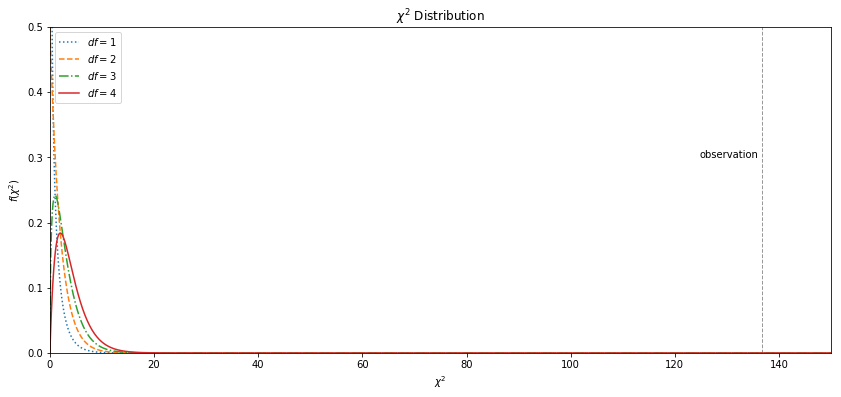

In [118]:
# Visualizing the probability of our chi2 distribution
X = np.linspace(0, 150, 1000)
fig, ax = plt.subplots(1, figsize=(14, 6))
linestyles = [':','--','-.','-']
degree_of_freedom = [1, 2, 3, 4]
for df, ls in zip(degree_of_freedom, linestyles):
    ax.plot(X, stats.chi2.pdf(X, df), linestyle=ls, label=r'$df=%i$' % df)

plt.xlim(0, 150)
plt.ylim(0, .5)

plt.xlabel('$\chi^2$')
plt.ylabel(r'$f(\chi^2)$')
plt.title(r'$\chi^2\ \mathrm{Distribution}$')

# Visualize the critical value
plt.vlines(chi_squared_stat, 0, .5, linewidth=1, linestyle='--', alpha=.4)
plt.text(chi_squared_stat-12, .3, 'observation')

plt.legend(loc='upper left')
plt.show()